In [1]:
import pandas as pd
from yahoo_fin import options
import numpy as np
import datetime
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import optimize
from scipy.stats import norm
import modulesForCalibration as mfc
import yfinance as yf

today = datetime.datetime.today()

In [2]:
# Gettting close price
tickers = ['META']
for ticker in tickers:
    ticker_yahoo = yf.Ticker(ticker)
    data = ticker_yahoo.history()
    last_quote = data['Close'].iloc[-1]
    print(ticker, last_quote)
meta_close = last_quote

META 296.7300109863281


In [3]:
# Defining risk free rate and dividend yield
# https://ycharts.com/indicators/10_year_treasury_rate
r = 0.0433
q = 0

In [4]:
# Downloading options data from yahoo finance
fb = yf.Ticker("META")
fb_df = pd.DataFrame()
for date in fb.options:
    calls = fb.option_chain(date).calls
    puts = fb.option_chain(date).puts
    calls['Option type'] = 'Call'
    calls['Maturity date'] = date
    puts['Maturity date'] = date
    puts['Option type'] = 'Put'
    fb_df = pd.concat([fb_df,calls,puts])

In [5]:
# Filter deep OTM and ITM
fb_df = fb_df.loc[(fb_df.strike > 0.5*meta_close) & (fb_df.strike <1.5*meta_close)]

In [6]:
fb_df.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Option type,Maturity date
4,META231103C00150000,2023-10-27 19:19:43+00:00,150.0,146.71,146.15,148.10,10.530014,7.732423,5.0,16,2.310551,True,REGULAR,USD,Call,2023-11-03
5,META231103C00160000,2023-10-27 14:20:27+00:00,160.0,136.10,136.15,138.00,-20.349990,-13.007344,3.0,9,2.070317,True,REGULAR,USD,Call,2023-11-03
6,META231103C00170000,2023-10-27 15:43:21+00:00,170.0,126.74,126.00,127.70,11.459999,9.941012,2.0,13,1.644533,True,REGULAR,USD,Call,2023-11-03
7,META231103C00175000,2023-10-27 15:31:07+00:00,175.0,120.34,121.45,122.60,-17.290009,-12.562674,18.0,10,1.757814,True,REGULAR,USD,Call,2023-11-03
8,META231103C00180000,2023-10-27 16:07:43+00:00,180.0,115.98,116.15,118.05,12.920006,12.536393,10.0,9,1.730470,True,REGULAR,USD,Call,2023-11-03


In [66]:
# Define strikes and maturities range
strikes = np.sort(fb_df.strike.unique())
fb_df['Maturity'] = fb_df['Maturity date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
fb_df['Days to maturity'] = (fb_df['Maturity'] - today).dt.days
maturities = np.sort(fb_df['Days to maturity'].unique())
print(f'Strikes: {strikes} \n Maturities: {maturities}')

Strikes: [150.  155.  160.  165.  170.  175.  180.  185.  190.  195.  200.  205.
 210.  215.  220.  225.  230.  235.  240.  245.  250.  255.  260.  265.
 270.  275.  280.  285.  290.  292.5 295.  297.5 300.  305.  310.  315.
 320.  325.  330.  335.  340.  345.  350.  355.  360.  365.  370.  375.
 380.  385.  390.  395.  400.  405.  410.  415.  420.  425.  430.  435.
 440.  445. ] 
 Maturities: [  5  12  19  26  33  47  82 110 138 173 236 327 446 600 691 782 810]


In [67]:
# Division by option type
fb_calls = fb_df[fb_df['Option type'] == 'Call'][['Days to maturity', 'strike', 'lastPrice']]
fb_puts = fb_df[fb_df['Option type'] == 'Put'][['Days to maturity', 'strike', 'lastPrice']]

In [68]:
# Interpolating option prices surfaces
X, Y = np.meshgrid(strikes, maturities)
callPrices = np.empty([len(maturities), len(strikes)])
putPrices = np.empty([len(maturities), len(strikes)])
for i in range(len(maturities)):
    s = fb_calls[fb_calls['Days to maturity'] == maturities[i]]['strike']
    price = fb_calls[fb_calls['Days to maturity'] == maturities[i]]['lastPrice']
    f = interpolate.interp1d(s, price, bounds_error=False, fill_value = 'extrapolate')
    callPrices[i, :] = f(strikes)
    s_p = fb_puts[fb_puts['Days to maturity'] == maturities[i]]['strike']
    price_p = fb_puts[fb_puts['Days to maturity'] == maturities[i]]['lastPrice']
    f_p = interpolate.interp1d(s_p, price_p, bounds_error=False, fill_value='extrapolate')
    putPrices[i, :] = f_p(strikes)

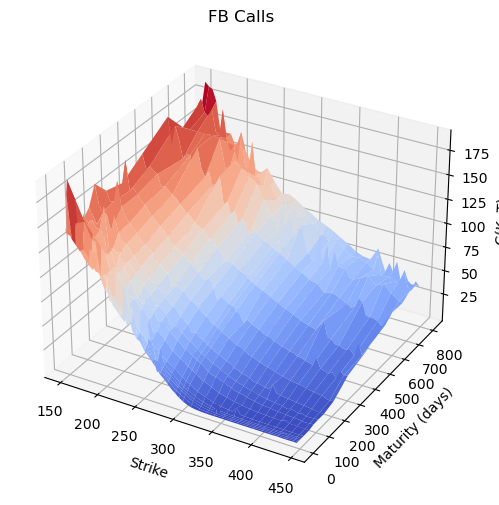

In [69]:
# Plotting calls
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, callPrices, cmap=cm.coolwarm)
ax.set_ylabel('Maturity (days)') 
ax.set_xlabel('Strike') 
ax.set_zlabel('C(K, T)')
ax.set_title('FB Calls')
plt.show()

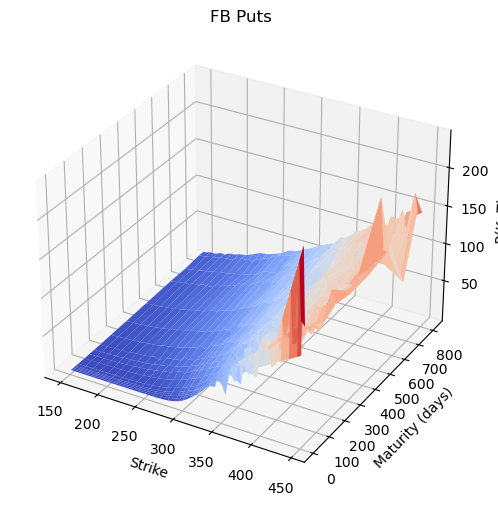

In [70]:
# Plot puts
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, putPrices, cmap=cm.coolwarm)
ax.set_ylabel('Maturity (days)') 
ax.set_xlabel('Strike') 
ax.set_zlabel('P(K, T)')
ax.set_title('FB Puts')
plt.show()

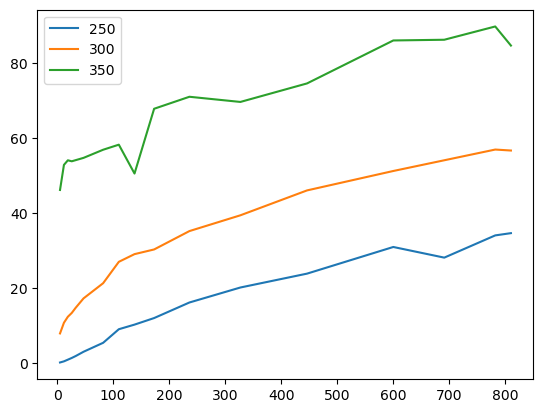

In [72]:
# Plotting 3 chosen strikes
strike1 = fb_puts.loc[fb_puts['strike'] == 250]
strike2 = fb_puts.loc[fb_puts['strike'] == 300]
strike3 = fb_puts.loc[fb_puts['strike'] == 350]
plt.plot(strike1['Days to maturity'], strike1['lastPrice'], label= '250')
plt.plot(strike2['Days to maturity'], strike2['lastPrice'], label= '300')
plt.plot(strike3['Days to maturity'], strike3['lastPrice'], label= '350')
plt.legend()
plt.show() # Just to check if it's not constant

In [74]:
# Functions to calculate and compare BS prices with market
def BS_d1(S, K, r, q, sigma, tau):
    ''' Computes d1 for the Black Scholes formula '''
    d1 = 1.0*(np.log(1.0 * S/K) + (r - q + sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d1

def BS_d2(S, K, r, q, sigma, tau):
    ''' Computes d2 for the Black Scholes formula '''
    d2 = 1.0*(np.log(1.0 * S/K) + (r - q - sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d2

def BS_price(type_option, S, K, r, q, sigma, T, t=0):
    ''' Computes the Black Scholes price for a 'call' or 'put' option '''
    tau = T - t
    d1 = BS_d1(S, K, r, q, sigma, tau)
    d2 = BS_d2(S, K, r, q, sigma, tau)
    if type_option == 'Call':
        price = S * np.exp(-q * tau) * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    elif type_option == 'Put':
        price = K * np.exp(-r * tau) * norm.cdf(-d2) - S * np.exp(-q * tau) * norm.cdf(-d1) 
    return price

def aux_imp_vol(sigma, P, type_option, S, K, r, q, T, t=0):
    ''' Calculates difference between market price and BS price'''
    bs = BS_price(type_option, S, K, r, q, sigma, T, t)
    return bs - P

def imp_vol(fun, a, b, args):
    ''' Finding root of difference between market and BS using Brents Method. Fallback is 0'''
    try:
        result = optimize.brentq(fun, a, b, args = args)
    except:
        result = 0
    return result

In [76]:
# Calculating implied volatility
fb_df['Years to maturity'] = fb_df['Days to maturity'] / 360
fb_df['Implied vol calc'] = fb_df.apply(lambda x: imp_vol(aux_imp_vol, -0.1, 10, args = (x['lastPrice'], x['Option type'], meta_close, 
                                                                           x['strike'], r, q, x['Years to maturity'])), axis=1)

In [77]:
# Number of fallbacks 
fb_df.loc[fb_df['Implied vol calc'] == 0]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Option type,Maturity date,Maturity,Days to maturity,Years to maturity,Implied vol calc


In [78]:
# Parameters
alpha = 1.5
eta = 0.2
model = 'Heston'
n = 12

In [79]:
# Range for each of Heston parameters
params1 = (1.0, 0.001, 0.01, -1, 0)
params2 = (20.0, 0.4, 0.6, +1, 5) 

In [80]:
# Starting with calibrating calls
marketPrices = callPrices
maturities_yr = maturities / 365

In [81]:
# Starting from params1 and going to param2 increasing each parameter by 5% of parameter range
iArray = []
rmseArray = []
rmseMin = 1e10 # Initial error value
for i in mfc.myRange(0, 1, 0.05):
    
    params = i*np.array(params1) + (1.0-i)*np.array(params2) # Defining parameters
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities_yr, strikes, r, q, meta_close, alpha, eta, n, model) # Calculating error function
    rmseArray.append(rmse)
    if (rmse < rmseMin): # Saving optimal results and its error
        rmseMin = rmse
        optimParams = params

print(rmseMin)
print(optimParams)

C:\Users\pawpi\Downloads\modulesForCalibration.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  xX[j] = cmath.exp(-1j*beta*nuJ[j])*df*psi_nuJ[j]*wJ
C:\Users\pawpi\Downloads\modulesForCalibration.py:100: RuntimeWarning: overflow encountered in tanh
  tmp2 = ((u*u+1j*u)*v0)/(g/np.tanh(g*T/2)+tmp)


7.144673069812168
[ 9.55     0.18055  0.2755  -0.1      2.25   ]


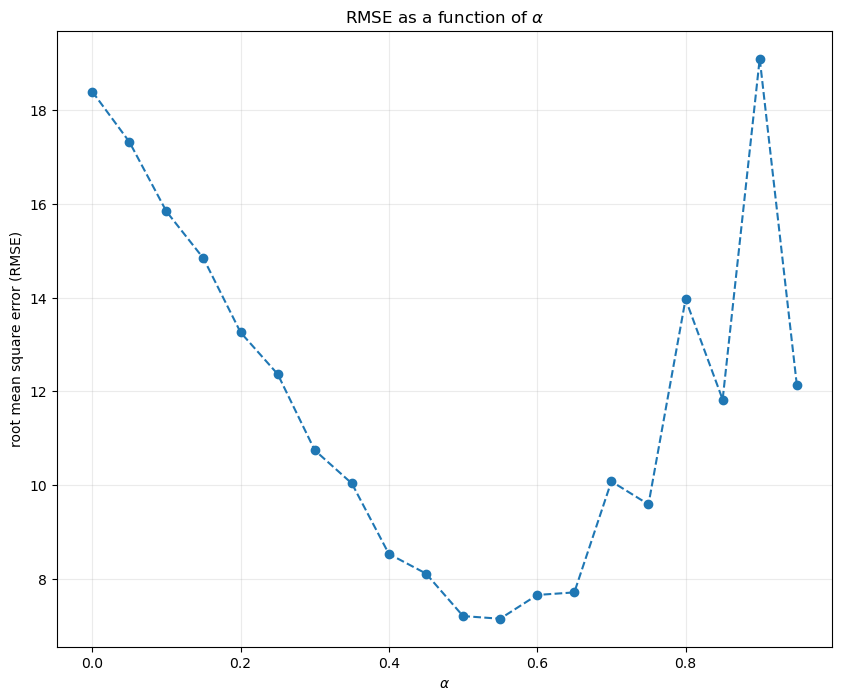

In [82]:
# Checking evolution of error value to determine correct starting point
fig = plt.figure(figsize=(10,8))
plt.plot(iArray, rmseArray, 'o--')
plt.grid(alpha=0.25)
plt.xlabel('$\\alpha$')
plt.ylabel('root mean square error (RMSE)')
plt.title('RMSE as a function of $\\alpha$')
plt.show()

In [ ]:
# Grid Search, please adjust ranges for each parameter before running 
ind_iter = 1
rmseMin = 1.0e6

for kappa in mfc.myRange(7.50,7.80,0.15):
    for theta in mfc.myRange(0.1,0.2,0.05):
        for sig in mfc.myRange(0.18,0.22,0.02):
            for rho in mfc.myRange(-0.4,-0.2,0.1):
                for v0 in mfc.myRange(1.65,1.85,0.1):
                    params = []
                    params.append(kappa)
                    params.append(theta)
                    params.append(sig)
                    params.append(rho)
                    params.append(v0)
                    
                    print('i = ' + str(ind_iter))
                    ind_iter += 1
                    print(params)
                    rmse = mfc.eValue(params, marketPrices, maturities_yr, strikes, r, q, meta_close, alpha, eta, n, model)
                    
                    if (rmse < rmseMin):
                        rmseMin = rmse
                        params2 = params
                        print('\nnew min found')
                        print(rmseMin)
                        print(params2)
                        print('')

print('\nSolution of grid search:')                        
print(params2)
print('Optimal rmse = ' + str(rmseMin))

In [ ]:
# Nelder Mead
from scipy.optimize import fmin
params = optimParams

def callbackF(xi):
    ''' Callback function to Nelder Mead optimizer'''
    global num_iter
    global arg
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities_yr, strikes, r, q, meta_close, alpha, eta, n, model)

num_iter = 1
#xopt, fopt, iters, funcalls, warnflag, allvecs = fmin(
t = fmin(
        mfc.eValue, 
        params, 
        args=arg, 
        xtol=1e-4,
        ftol=1e-4,
        maxiter=50,
        maxfun=400,
        callback=callbackF,
        disp=True,
        retall=False,
        full_output=True)

print('optimal params = ')
print(t[0])
print('f = ' + str(t[1]))

i = 1
x_i = [ 9.55     0.18055  0.2755  -0.1      2.3625 ]
f_i = 7.085430940011538
i = 2
x_i = [ 9.8174    0.176939  0.283214 -0.1028    2.313   ]
f_i = 7.0820307241961284
i = 3
x_i = [ 9.8174    0.176939  0.283214 -0.1028    2.313   ]
f_i = 7.0820307241961284
i = 4
x_i = [ 9.8174    0.176939  0.283214 -0.1028    2.313   ]
f_i = 7.0820307241961284
i = 5
x_i = [ 9.8174    0.176939  0.283214 -0.1028    2.313   ]
f_i = 7.0820307241961284
i = 6
x_i = [ 9.80216584  0.18462465  0.28244392 -0.09803248  2.3364108 ]
f_i = 7.0755939714704725
i = 7
x_i = [ 9.80216584  0.18462465  0.28244392 -0.09803248  2.3364108 ]
f_i = 7.0755939714704725
i = 8
x_i = [ 9.80216584  0.18462465  0.28244392 -0.09803248  2.3364108 ]
f_i = 7.0755939714704725
i = 9
x_i = [ 9.80216584  0.18462465  0.28244392 -0.09803248  2.3364108 ]
f_i = 7.0755939714704725
i = 10
x_i = [ 9.80216584  0.18462465  0.28244392 -0.09803248  2.3364108 ]
f_i = 7.0755939714704725
i = 11
x_i = [ 9.80216584  0.18462465  0.28244392 -0.09803248  2.

In [ ]:
params2 = t[0]
lenT = len(maturities)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities_yr[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, meta_close, K, r, q, T, alpha, eta, n, model)
        modelPrices[i,j] = cT_km[0]


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral

for i in range(len(maturities)):
    plt.plot(strikes, callPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model')

plt.show() 